In [1]:
from parameters import get_parameters

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
params = get_parameters()

target = params["target"]
source_conformed = params["source_conformed"]
source_model = params["source_model"]
corr_method = params["corr_method"]
max_lag = params["max_lag"]

In [3]:
PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\dxnin\Documents\dengue-forecast


In [4]:
df = pd.read_pickle(f"{PROJECT_ROOT}/{source_conformed}/data.pkl")
df.head()

,CASES,PRECIPITATION_AVG_MAX,RUNOFF_AVG_MAX,TEMPERATURE_AVG_MAX,WIND_AVG_MAX
DATE,,,,,
2007-01-07,0,0.829115,0.057710,21.954080,2.847873
2007-01-14,0,4.017773,0.367180,22.923341,3.972641
2007-01-21,0,8.691750,1.045510,23.034158,3.766555
2007-01-28,0,13.806932,1.639757,24.142465,4.537634
2007-02-04,0,1.075573,0.077687,26.059118,5.366861


In [5]:
def forward_feature_selection(df,
                              target_column="CASES",
                              model=None,
                              metric="r2",
                              max_features=None,
                              cv_folds=5,
                              random_state=42,
                              plot_progress=True):

    # Data preparation
    df = df.copy()
    if "DATE" in df.columns:
        df = df.drop(columns=["DATE"])
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    df = df[numeric_cols]

    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Scaling
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Base model
    if model is None:
        model = RandomForestRegressor(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        )

    # Metric to optimize
    valid_metrics = ["r2", "rmse", "mae"]
    if metric.lower() not in valid_metrics:
        raise ValueError(f"Invalid metric. Must be one of: {valid_metrics}")

    scoring_map = {
        "r2": "r2",
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error"
    }
    scoring = scoring_map[metric.lower()]

    # Forward Selection Loop
    remaining_features = list(X_scaled.columns)
    selected_features = []
    best_scores = []
    iteration = 0

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    print("🚀 Starting Forward Feature Selection...\n")

    while remaining_features:
        iteration += 1
        scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_subset = X_scaled[current_features]
            cv_score = cross_val_score(model, X_subset, y, cv=kf, scoring=scoring).mean()

            if metric.lower() in ["rmse", "mae"]:
                cv_score = -cv_score

            scores[feature] = cv_score

        if metric.lower() == "r2":
            best_feature = max(scores, key=scores.get)
        else:
            best_feature = min(scores, key=scores.get)

        best_feature_score = scores[best_feature]
        print(f"Iteration {iteration}: adding '{best_feature}' → {metric.upper()}: {best_feature_score:.4f}")

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_scores.append(best_feature_score)

        if max_features and len(selected_features) >= max_features:
            break

        # Early stopping if metric worsens twice in a row
        if len(best_scores) > 3:
            if metric.lower() == "r2":
                if best_scores[-1] < best_scores[-2] and best_scores[-2] < best_scores[-3]:
                    print("⚠️ Metric worsened twice consecutively. Stopping search.")
                    break
            else:
                if best_scores[-1] > best_scores[-2] and best_scores[-2] > best_scores[-3]:
                    print("⚠️ Metric worsened twice consecutively. Stopping search.")
                    break

    # Determine best index (for plotting and summary)
    if metric.lower() in ["rmse", "mae"]:
        best_idx = np.argmin(best_scores)
    else:
        best_idx = np.argmax(best_scores)
    best_value = best_scores[best_idx]

    # Final fitting
    X_selected = X_scaled[selected_features[: best_idx + 1]]
    model.fit(X_selected, y)

    # Results
    results_df = pd.DataFrame({
        "feature_added": selected_features,
        metric: best_scores
    })

    if plot_progress:
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=results_df, x="feature_added", y=metric, linewidth=2)

        # Add vertical dashed line at the best model
        plt.axvline(best_idx, linestyle="--", color="red", label="Best model")

        plt.title(f"Forward feature selection progress ({metric.upper()})")
        plt.xlabel("Added features")
        plt.ylabel(metric.upper())
        plt.xticks()
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    print("\n✅ Forward Selection completed")
    print(f"Selected features ({best_idx + 1}): {selected_features[: best_idx + 1]}")
    print(f"Best {metric.upper()}: {best_value:.4f} (at {best_idx + 1} features)")

    return {
        "selected_features": selected_features[: best_idx + 1],
        "feature_performance": results_df,
        "best_model": model,
        "best_iteration": best_idx + 1,
        "best_score": best_value
    }


In [6]:
def correlation_lag_analysis(df, min_lag=1, max_lag=5, corr_method="spearman"):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    if corr_method not in ("spearman", "pearson"):
        raise ValueError("corr_method must be 'spearman' or 'pearson'")

    if "CASES" not in df.columns:
        raise ValueError("DataFrame must contain the 'CASES' column")

    if min_lag < 1 or max_lag < min_lag:
        raise ValueError("Invalid lag range: ensure 1 <= min_lag <= max_lag")

    # ---- Variables to analyze in specific order ----
    base_order = [
        "TEMPERATURE_AVG_MAX",
        "RUNOFF_AVG_MAX",
        "PRECIPITATION_AVG_MAX",
        "WIND_AVG_MAX",
    ]

    variables = [v for v in base_order if v in df.columns]

    if not variables:
        raise ValueError("No matching variables found among the specified list.")

    # ---- Create lagged features ----
    lag_cols = {}
    for var in variables:
        for lag in range(min_lag, max_lag + 1):
            colname = f"{var}_LAG{lag}"
            lag_cols[colname] = df[var].shift(lag)
    lag_df = pd.DataFrame(lag_cols, index=df.index)

    # ---- Correlation matrix ----
    corr_matrix = pd.DataFrame(index=variables, columns=range(min_lag, max_lag + 1), dtype=float)
    y = df["CASES"]

    for var in variables:
        for lag in range(min_lag, max_lag + 1):
            x = lag_df[f"{var}_LAG{lag}"]
            mask = y.notna() & x.notna()
            corr_matrix.loc[var, lag] = y[mask].corr(x[mask], method=corr_method) if mask.any() else np.nan

    # ---- Plot heatmap ----
    fig, ax = plt.subplots(figsize=(15, 4))
    im = ax.imshow(corr_matrix.values.astype(float), cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
    ax.set_title(f"{corr_method.capitalize()} correlation matrix between dengue cases and lagged climatic variables")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Variable")

    ax.set_xticks(np.arange(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_yticks(np.arange(len(variables)))
    ax.set_yticklabels(variables)

    # Annotate values
    for i, var in enumerate(variables):
        for j, lag in enumerate(corr_matrix.columns):
            val = corr_matrix.loc[var, lag]
            txt = "" if pd.isna(val) else f"{val:.2f}"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Correlation")

    plt.tight_layout()
    plt.show()

    # ---- Select best lag per variable ----
    abs_argmax = corr_matrix.abs().idxmax(axis=1)
    rows = np.arange(corr_matrix.shape[0])
    cols = abs_argmax.values.astype(int) - min_lag
    best_values = corr_matrix.to_numpy()[rows, cols]

    selected_cols = ["CASES"] + [f"{var}_LAG{lag}" for var, lag in zip(corr_matrix.index, abs_argmax.values)]
    df_selected = pd.concat([df[["CASES"]], lag_df[[c for c in selected_cols if c != "CASES"]]], axis=1)

    # ---- Summary ----
    summary = pd.DataFrame({
        "Variable": corr_matrix.index,
        "Best_Lag": abs_argmax.values,
        "Correlation": best_values
    }).reset_index(drop=True)
    print("\nMost correlated lags per variable:")
    print(summary)

    return df_selected


In [7]:
def plot_lagged_correlation_matrix(df, corr_method="spearman", include_cases=False):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- Validaciones ----
    if corr_method not in ("spearman", "pearson"):
        raise ValueError("corr_method debe ser 'spearman' o 'pearson'")

    # ---- Orden base de variables ----
    base_order = [
        "TEMPERATURE_AVG_MAX",
        "RUNOFF_AVG_MAX",
        "PRECIPITATION_AVG_MAX",
        "WIND_AVG_MAX",
    ]

    # ---- Seleccionar columnas laggeadas en ese orden ----
    cols = []
    if include_cases == True:
        cols.extend(["CASES"])
    for base in base_order:
        cols.extend(sorted([c for c in df.columns if c.startswith(base)]))

    if not cols:
        raise ValueError("No se encontraron columnas laggeadas válidas en el DataFrame.")

    # ---- Calcular matriz de correlación ----
    corr_matrix = df[cols].corr(method=corr_method)

    # ---- Crear máscara para ocultar parte superior ----
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    # ---- Graficar ----
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(np.where(mask, np.nan, corr_matrix), cmap="coolwarm", vmin=-1, vmax=1, aspect="equal")

    # Etiquetas
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols, rotation=90, fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)

    # Anotar valores visibles
    for i in range(len(cols)):
        for j in range(len(cols)):
            if not mask[i, j]:
                val = corr_matrix.iloc[i, j]
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=6)

    # Barra de color
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Correlation")

    ax.set_title(f"Correlation matrix of lagged climate variables ({corr_method.capitalize()})")
    plt.tight_layout()
    plt.show()

    return corr_matrix

## Lag dengue

In [8]:
# Lag dengue cases
df_lag = df[["CASES"]].copy()

df_lag["CASES_LAG1"] = df_lag["CASES"].shift(1)
df_lag["CASES_LAG5"] = df_lag["CASES"].shift(5)
df_lag["CASES_LAG2"] = df_lag["CASES"].shift(2)
df_lag["CASES_LAG16"] = df_lag["CASES"].shift(16)
df_lag["CASES_LAG18"] = df_lag["CASES"].shift(18)
df_lag["CASES_LAG3"] = df_lag["CASES"].shift(3)
df_lag["CASES_LAG7"] = df_lag["CASES"].shift(7)
df_lag["CASES_LAG13"] = df_lag["CASES"].shift(13)
df_lag["CASES_LAG19"] = df_lag["CASES"].shift(19)
df_lag["CASES_LAG8"] = df_lag["CASES"].shift(8)

🚀 Starting Forward Feature Selection...

Iteration 1: adding 'CASES_LAG1' → RMSE: 13.3789
Iteration 2: adding 'CASES_LAG18' → RMSE: 11.6579
Iteration 3: adding 'CASES_LAG16' → RMSE: 11.3058
Iteration 4: adding 'CASES_LAG3' → RMSE: 11.1097
Iteration 5: adding 'CASES_LAG7' → RMSE: 11.1559
Iteration 6: adding 'CASES_LAG13' → RMSE: 11.1885
⚠️ Metric worsened twice consecutively. Stopping search.


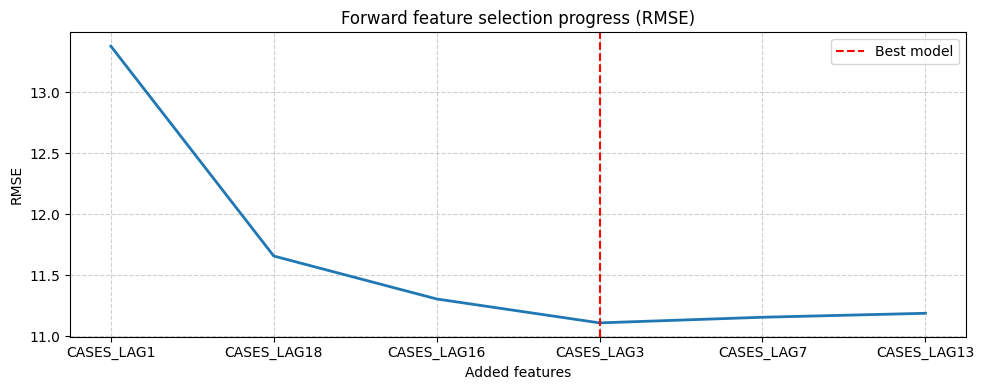


✅ Forward Selection completed
Selected features (4): ['CASES_LAG1', 'CASES_LAG18', 'CASES_LAG16', 'CASES_LAG3']
Best RMSE: 11.1097 (at 4 features)


In [9]:
results = forward_feature_selection(
            df_lag.copy(),
            target_column="CASES",
            model=None,
            metric="rmse",
            max_features=None,
            cv_folds=5,
            random_state=123,
            plot_progress=True
        )

In [10]:
selected_features = results["selected_features"]
feature_performance = results["feature_performance"]
print(selected_features)
print(feature_performance)

['CASES_LAG1', 'CASES_LAG18', 'CASES_LAG16', 'CASES_LAG3']
  feature_added       rmse
0    CASES_LAG1  13.378935
1   CASES_LAG18  11.657917
2   CASES_LAG16  11.305796
3    CASES_LAG3  11.109705
4    CASES_LAG7  11.155893
5   CASES_LAG13  11.188453


In [11]:
df_lag = df_lag[["CASES"] + selected_features]
df_lag.head()

,CASES,CASES_LAG1,CASES_LAG18,CASES_LAG16,CASES_LAG3
DATE,,,,,
2007-01-07,0,NaN,NaN,NaN,NaN
2007-01-14,0,0.0,NaN,NaN,NaN
2007-01-21,0,0.0,NaN,NaN,NaN
2007-01-28,0,0.0,NaN,NaN,0.0
2007-02-04,0,0.0,NaN,NaN,0.0


## Correlation climatic variables

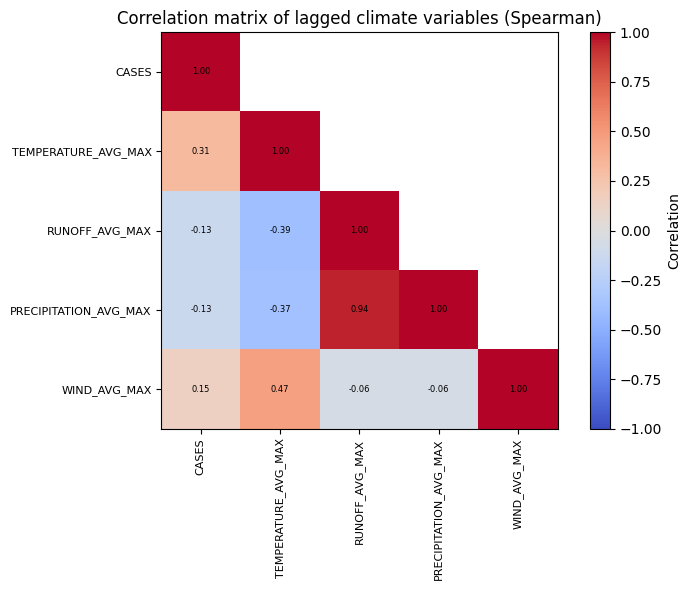

In [12]:
corr = plot_lagged_correlation_matrix(df, corr_method="spearman", include_cases=True)

In [13]:
pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns).var()

CASES                    0.018556
PRECIPITATION_AVG_MAX    0.018156
RUNOFF_AVG_MAX           0.011620
TEMPERATURE_AVG_MAX      0.031048
WIND_AVG_MAX             0.023747
dtype: float64

In [14]:
df.var()

CASES                    2750.455845
PRECIPITATION_AVG_MAX      74.324676
RUNOFF_AVG_MAX             20.900761
TEMPERATURE_AVG_MAX         1.926548
WIND_AVG_MAX                0.914010
dtype: float64

## Lag climate variables

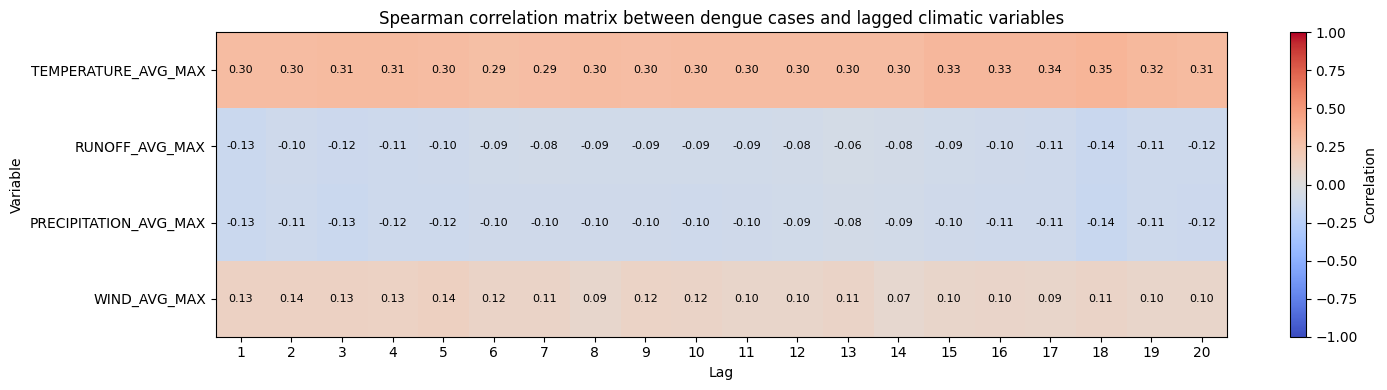


Most correlated lags per variable:
                Variable  Best_Lag  Correlation
0    TEMPERATURE_AVG_MAX        18     0.348563
1         RUNOFF_AVG_MAX        18    -0.135741
2  PRECIPITATION_AVG_MAX        18    -0.142169
3           WIND_AVG_MAX         5     0.144884


In [15]:
df_lag_climate = correlation_lag_analysis(df, min_lag=1, max_lag=20, corr_method="spearman")

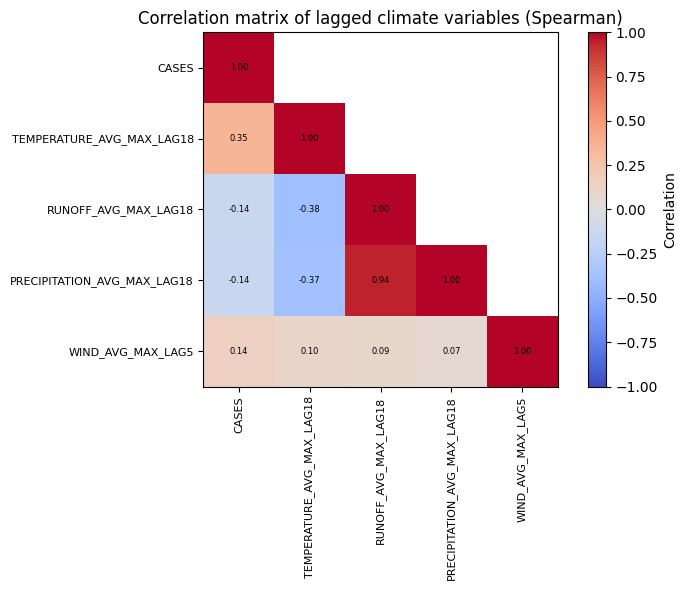

In [16]:
corr = plot_lagged_correlation_matrix(df_lag_climate, corr_method="spearman", include_cases=True)

In [17]:
df_lag_climate = df_lag_climate.drop(columns=["CASES", "RUNOFF_AVG_MAX_LAG18"])

## Merge results

In [18]:
# Merge df_lag and df_lag_climate on index
df_lag = pd.concat([df_lag, df_lag_climate], axis=1)

In [19]:
df_lag = df_lag.dropna()

In [20]:
df_lag = df_lag.asfreq('W')

In [21]:
df_lag.head()

,CASES,CASES_LAG1,CASES_LAG18,CASES_LAG16,CASES_LAG3,TEMPERATURE_AVG_MAX_LAG18,PRECIPITATION_AVG_MAX_LAG18,WIND_AVG_MAX_LAG5
DATE,,,,,,,,
2007-05-13,0,0.0,0.0,0.0,0.0,21.954080,0.829115,5.413678
2007-05-20,0,0.0,0.0,0.0,0.0,22.923341,4.017773,4.686905
2007-05-27,0,0.0,0.0,0.0,0.0,23.034158,8.691750,5.178932
2007-06-03,0,0.0,0.0,0.0,0.0,24.142465,13.806932,4.721500
2007-06-10,0,0.0,0.0,0.0,0.0,26.059118,1.075573,5.410017


In [22]:
df_lag.to_pickle(f"{PROJECT_ROOT}/{source_model}/data.pkl")